In [1]:
import sys; sys.path.insert(0, '../..')

import fenics as fa
import matplotlib.pyplot as plt
import mshr
import numpy as np
import pdb
import argparse
import jax
from collections import namedtuple

from src.linear_stokes.linear_stokes_common import (
    plot_solution,
    loss_fn,
    fenics_to_jax,
    SecondOrderTaylorLookup,
    error_on_coords,
    sample_params,
    sample_points,
    loss_divu_fn,
    loss_stress_fn,
    get_p,
    get_u,
    deviatoric_stress
)

from src.linear_stokes.linear_stokes_fenics import (
    solve_fenics,
    is_defined,
    parser
)

In [59]:
args = parser.parse_args("")
args.bc_scale = 10.
args = namedtuple("ArgsTuple", vars(args))(**vars(args))

params = sample_params(jax.random.PRNGKey(args.seed), args)
source_params, bc_params, per_hole_params, num_holes = params
print("params: ", params)

params:  (DeviceArray([0.4130522 , 0.25975317], dtype=float32), DeviceArray([3.000803], dtype=float32), DeviceArray([[ 0.04156993, -0.0613506 ,  0.47837767,  0.20494777,
               0.44709057],
             [-0.03926784, -0.11530625,  0.10562178,  0.4114218 ,
               0.35706055],
             [-0.04186818,  0.01709074,  0.18381561, -0.53561956,
               0.29799348]], dtype=float32), DeviceArray(1, dtype=int32))


In [60]:
u_p = solve_fenics(params, boundary_points=32, resolution=128)

In [61]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

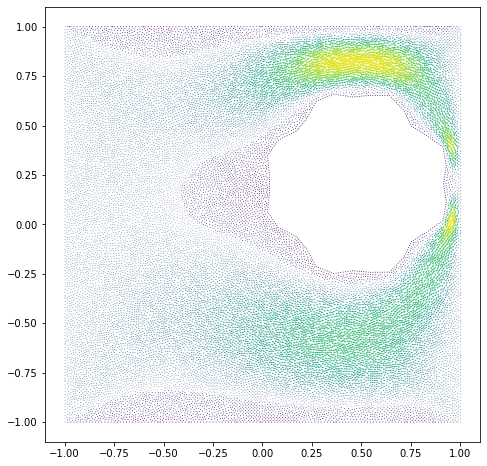

In [62]:
u, p = u_p.split()
plt.figure(figsize=(8,8))
fa.plot(u)
plt.show()

In [63]:
x0 = points_in_domain[120]

In [64]:
taylor = SecondOrderTaylorLookup(u_p, all_points, d = 3)

# Loss Function 

6507.6567 0.06197911
0.2923292 1.0127702e-06


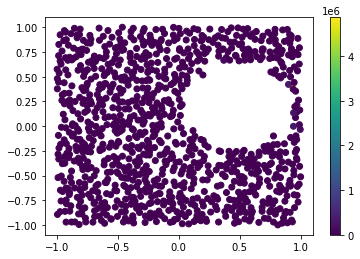

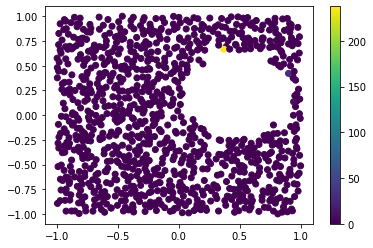

In [98]:
jax_stress_loss = loss_stress_fn(taylor, points_in_domain, params)
jax_divu_loss = loss_divu_fn(taylor, points_in_domain, params)

print(np.mean(jax_stress_loss, axis=0), np.median(jax_stress_loss, axis=0))
print(np.mean(jax_divu_loss, axis=0), np.median(jax_divu_loss, axis=0))

plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.array(jax_stress_loss))
plt.colorbar(clrs)
plt.show()

plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.array(jax_divu_loss))
plt.colorbar(clrs)
plt.show()

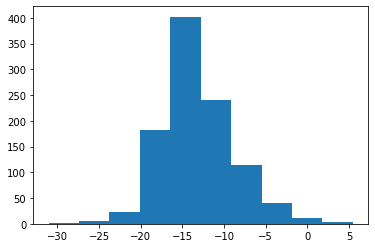

In [66]:
plt.figure()
plt.hist(np.log(jax_divu_loss))
plt.show()

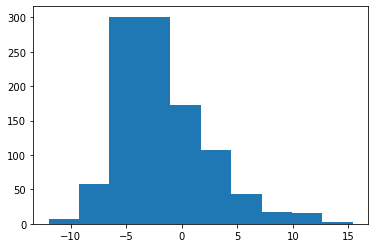

In [67]:
plt.figure()
plt.hist(np.log(jax_stress_loss))
plt.show()

In [68]:
u, p = fa.split(u_p)

In [69]:
div_u_fenics = fa.div(u)

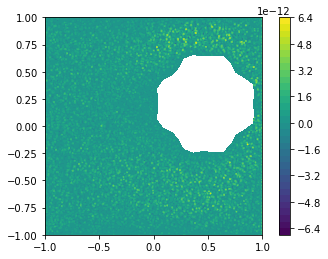

In [70]:
clrs = fa.plot(div_u_fenics)
plt.colorbar(clrs)

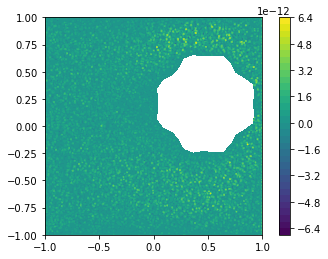

In [71]:
trace_jac_u_fenics = fa.tr(fa.grad(u))
clrs = fa.plot(trace_jac_u_fenics)
plt.colorbar(clrs)

In [72]:
fa.assemble(div_u_fenics*fa.dx)

1.8223147970338386e-14

In [73]:
jac_u = fa.project(fa.grad(u), 
                   fa.TensorFunctionSpace(u_p.function_space().mesh(), 'P', 2, (2, 2)), solver_type="mumps")

In [74]:
jac_u([0., 0.]).reshape(2,2)

array([[-6.5331258 , -8.57841763],
       [ 7.04891479,  6.5242604 ]])

In [75]:
jac_u([-0.02, -0.02]).reshape(2,2)

array([[-5.7557918 , -9.10962402],
       [ 4.86156115,  5.7548466 ]])

5.099482327807974

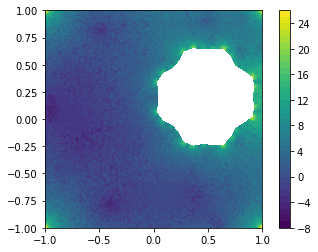

In [76]:
div_gradu_minus_p = fa.div(fa.grad(u) - p * fa.Identity(2))

lognorm = fa.ln(fa.inner(div_gradu_minus_p, div_gradu_minus_p))
clrs = fa.plot(lognorm)
plt.colorbar(clrs)

fa.assemble(lognorm*fa.dx)

In [84]:
V = u_p.function_space()
mesh = V.mesh()
degree = V.ufl_element().degree()
W = fa.VectorFunctionSpace(mesh, 'CG', degree, dim = 2)
div_gradu_minus_p_fn = fa.project(div_gradu_minus_p, W, solver_type='mumps')

Calling FFC just-in-time (JIT) compiler, this may take some time.


Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling form ffc_form_6926516b0ee0a4e55efcd6e459f3345390217d18

INFO:FFC:Compiler stage 1: Analyzing form(s)
INFO:FFC:-----------------------------------
DEBUG:FFC:  Preprocessing form using 'uflacs' representation family.
INFO:FFC:  
INFO:FFC:  Geometric dimension:       2
  Number of cell subdomains: 0
  Rank:                      1
  Arguments:                 '(v_0)'
  Number of coefficients:    1
  Coefficients:              '[f_675]'
  Unique elements:           'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG1(
                             ?,?)>, Vector<2 x CG1(?,?)>'
  Unique sub elements:       'Vector<2 x CG2(?,?)>, Mixed<Vector<2 x CG2(?,?)>, CG1(
                             ?,?)>, Vector<2 x CG1(?,?)>, CG2(?,?), CG1(?,?)'
  
INFO:FFC:  representation:    auto --> uflacs
INFO:FFC:  quadrature_rule:   auto --> default
INFO:FFC:  quadrature_degree: auto --> 3
INFO:FFC:  quadrature_d

In [90]:
div_gradu_minus_p_val = []
div_gradu_minus_p_fn.set_allow_extrapolation(True)
for pt in all_points:
    div_gradu_minus_p_val.append(div_gradu_minus_p_fn(pt))
div_gradu_minus_p_fn.set_allow_extrapolation(False)

(2218, 2)


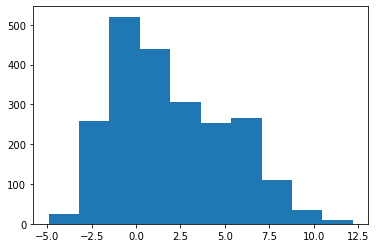

In [99]:
div_gradu_minus_p_val = np.array(div_gradu_minus_p_val)
print(div_gradu_minus_p_val.shape)
 
plt.figure()
plt.hist(np.log(np.linalg.norm(div_gradu_minus_p_val, axis = 1)))
plt.show()

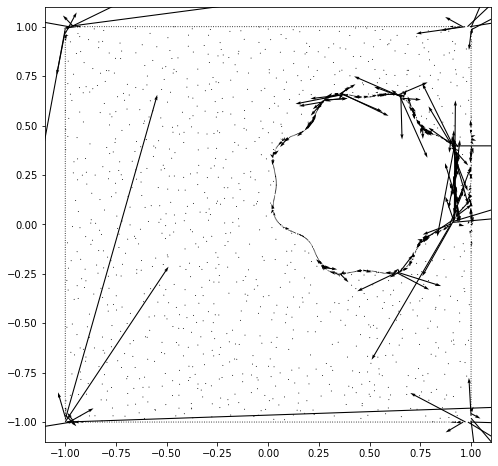

In [96]:
plt.figure(figsize = (8,8))
plt.quiver(all_points[:,0],all_points[:,1],div_gradu_minus_p_val[:,0],div_gradu_minus_p_val[:,1])

In [ ]:
u_p = solve_fenics(params, boundary_points=128, resolution=128)

In [ ]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

In [ ]:
u, p = u_p.split()
fa.plot(u)

In [ ]:
x0 = points_in_domain[120]

In [ ]:
taylor = SecondOrderTaylorLookup(u_p, all_points, d = 3)

# Loss Function 

In [ ]:
jax_stress_loss = loss_stress_fn(taylor, points_in_domain, params)
jax_divu_loss = loss_divu_fn(taylor, points_in_domain, params)

print(np.mean(jax_stress_loss, axis=0))
print(np.mean(jax_divu_loss, axis=0))

plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.array(jax_stress_loss))
plt.colorbar(clrs)
plt.show()

plt.figure()
clrs = plt.scatter(points_in_domain[:,0], points_in_domain[:,1], c = np.array(jax_divu_loss))
plt.colorbar(clrs)
plt.show()

In [ ]:
plt.figure()
plt.hist(np.log(jax_divu_loss))
plt.show()

In [ ]:
plt.figure()
plt.hist(np.log(jax_stress_loss))
plt.show()

In [ ]:
u, p = fa.split(u_p)

In [ ]:
div_u_fenics = fa.div(u)

In [ ]:
clrs = fa.plot(div_u_fenics)
plt.colorbar(clrs)

In [ ]:
trace_jac_u_fenics = fa.tr(fa.grad(u))
clrs = fa.plot(trace_jac_u_fenics)
plt.colorbar(clrs)

In [ ]:
fa.assemble(div_u_fenics*fa.dx)

In [ ]:
jac_u = fa.project(fa.grad(u), fa.TensorFunctionSpace(u_p.function_space().mesh(), 'P', 2, (2, 2)))

In [ ]:
jac_u([0., 0.]).reshape(2,2)

In [ ]:
jac_u([-0.02, -0.02]).reshape(2,2)

In [ ]:
div_gradu_minus_p = fa.div(fa.grad(u) - p * fa.Identity(2))

lognorm = fa.ln(fa.inner(div_gradu_minus_p, div_gradu_minus_p))

clrs = fa.plot(lognorm)
plt.colorbar(clrs)

fa.assemble(lognorm*fa.dx)